# FCN图像语义分割

全卷积网络（Fully Convolutional Networks，FCN）是UC Berkeley的Jonathan Long等人于2015年在Fully Convolutional Networks for Semantic Segmentation<sup>[1]</sup>一文中提出的用于图像语义分割的一种框架。

FCN是首个端到端（end to end）进行像素级（pixel level）预测的全卷积网络。

![fcn-1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_1.png)

## 语义分割

在具体介绍FCN之前，首先介绍何为语义分割：

图像语义分割（semantic segmentation）是图像处理和机器视觉技术中关于图像理解的重要一环，AI领域中一个重要分支，常被应用于人脸识别、物体检测、医学影像、卫星图像分析、自动驾驶感知等领域。

语义分割的目的是对图像中每个像素点进行分类。与普通的分类任务只输出某个类别不同，语义分割任务输出与输入大小相同的图像，输出图像的每个像素对应了输入图像每个像素的类别。语义在图像领域指的是图像的内容，对图片意思的理解，下图是一些语义分割的实例：

![fcn-2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_2.png)

## 模型简介

FCN主要用于图像分割领域，是一种端到端的分割方法，是深度学习应用在图像语义分割的开山之作。通过进行像素级的预测直接得出与原图大小相等的label map。因FCN丢弃全连接层替换为全卷积层，网络所有层均为卷积层，故称为全卷积网络。

全卷积神经网络主要使用以下三种技术：

1. 卷积化（Convolutional）

    使用VGG-16作为FCN的backbone。VGG-16的输入为224*224的RGB图像，输出为1000个预测值。VGG-16只能接受固定大小的输入，丢弃了空间坐标，产生非空间输出。VGG-16中共有三个全连接层，全连接层也可视为带有覆盖整个区域的卷积。将全连接层转换为卷积层能使网络输出由一维非空间输出变为二维矩阵，利用输出能生成输入图片映射的heatmap。

   ![fcn-3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_3.png)

2. 上采样（Upsample）

    在卷积过程的卷积操作和池化操作会使得特征图的尺寸变小，为得到原图的大小的稠密图像预测，需要对得到的特征图进行上采样操作。使用双线性插值的参数来初始化上采样逆卷积的参数，后通过反向传播来学习非线性上采样。在网络中执行上采样，以通过像素损失的反向传播进行端到端的学习。

    ![fcn-4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_4.png)

3. 跳跃结构（Skip Layer）

    利用上采样技巧对最后一层的特征图进行上采样得到原图大小的分割是步长为32像素的预测，称之为FCN-32s。由于最后一层的特征图太小，损失过多细节，采用skips结构将更具有全局信息的最后一层预测和更浅层的预测结合，使预测结果获取更多的局部细节。将底层（stride 32）的预测（FCN-32s）进行2倍的上采样得到原尺寸的图像，并与从pool4层（stride 16）进行的预测融合起来（相加），这一部分的网络被称为FCN-16s。随后将这一部分的预测再进行一次2倍的上采样并与从pool3层得到的预测融合起来，这一部分的网络被称为FCN-8s。 Skips结构将深层的全局信息与浅层的局部信息相结合。

    ![fcn-5](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_5.png)

## 网络特点

1. 不含全连接层(fc)的全卷积(fully conv)网络，可适应任意尺寸输入。  
2. 增大数据尺寸的反卷积(deconv)层，能够输出精细的结果。  
3. 结合不同深度层结果的跳级(skip)结构，同时确保鲁棒性和精确性。


## 设置运行环境

 max_device_memory="2GB" : 设置设备可用的最大内存为2GB。

 mode=mindspore.GRAPH_MODE : 表示在GRAPH_MODE模式中运行。

 device_target="Ascend" : 表示待运行的目标设备为Ascend。

 jit_config={"jit_level":"O2"} : 编译优化级别开启极致性能优化，使用下沉的执行方式。

 scend_config={"precision_mode":"allow_mix_precision"} : 自动混合精度，自动将部分算子的精度降低到float16或bfloat16。

In [ ]:
import mindspore
mindspore.set_context(max_device_memory="2GB", mode=mindspore.GRAPH_MODE, device_target="Ascend", jit_config={"jit_level":"O2"}, ascend_config={"precision_mode":"allow_mix_precision"})

## 数据处理

In [1]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/dataset_fcn8s.tar"

download(url, "./dataset", kind="tar", replace=True)


file_sizes: 100%|████████████████████████████| 563M/563M [00:44<00:00, 12.6MB/s]
Extracting tar file...
Successfully downloaded / unzipped to ./dataset


'./dataset'

### 数据预处理

由于PASCAL VOC 2012数据集中图像的分辨率大多不一致，无法放在一个tensor中，故输入前需做标准化处理。

### 数据加载

将PASCAL VOC 2012数据集与SDB数据集进行混合。

In [2]:
import numpy as np
import cv2
import mindspore.dataset as ds

class SegDataset:
    def __init__(self,
                 image_mean,
                 image_std,
                 data_file='',
                 batch_size=32,
                 crop_size=512,
                 max_scale=2.0,
                 min_scale=0.5,
                 ignore_label=255,
                 num_classes=21,
                 num_readers=2,
                 num_parallel_calls=4):

        self.data_file = data_file
        self.batch_size = batch_size
        self.crop_size = crop_size
        self.image_mean = np.array(image_mean, dtype=np.float32)
        self.image_std = np.array(image_std, dtype=np.float32)
        self.max_scale = max_scale
        self.min_scale = min_scale
        self.ignore_label = ignore_label
        self.num_classes = num_classes
        self.num_readers = num_readers
        self.num_parallel_calls = num_parallel_calls
        max_scale > min_scale

    def preprocess_dataset(self, image, label):
        image_out = cv2.imdecode(np.frombuffer(image, dtype=np.uint8), cv2.IMREAD_COLOR)
        label_out = cv2.imdecode(np.frombuffer(label, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        sc = np.random.uniform(self.min_scale, self.max_scale)
        new_h, new_w = int(sc * image_out.shape[0]), int(sc * image_out.shape[1])
        image_out = cv2.resize(image_out, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        label_out = cv2.resize(label_out, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        image_out = (image_out - self.image_mean) / self.image_std
        out_h, out_w = max(new_h, self.crop_size), max(new_w, self.crop_size)
        pad_h, pad_w = out_h - new_h, out_w - new_w
        if pad_h > 0 or pad_w > 0:
            image_out = cv2.copyMakeBorder(image_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
            label_out = cv2.copyMakeBorder(label_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=self.ignore_label)
        offset_h = np.random.randint(0, out_h - self.crop_size + 1)
        offset_w = np.random.randint(0, out_w - self.crop_size + 1)
        image_out = image_out[offset_h: offset_h + self.crop_size, offset_w: offset_w + self.crop_size, :]
        label_out = label_out[offset_h: offset_h + self.crop_size, offset_w: offset_w+self.crop_size]
        if np.random.uniform(0.0, 1.0) > 0.5:
            image_out = image_out[:, ::-1, :]
            label_out = label_out[:, ::-1]
        image_out = image_out.transpose((2, 0, 1))
        image_out = image_out.copy()
        label_out = label_out.copy()
        label_out = label_out.astype("int32")
        return image_out, label_out

    def get_dataset(self):
        ds.config.set_numa_enable(True)
        dataset = ds.MindDataset(self.data_file, columns_list=["data", "label"],
                                 shuffle=True, num_parallel_workers=self.num_readers)
        transforms_list = self.preprocess_dataset
        dataset = dataset.map(operations=transforms_list, input_columns=["data", "label"],
                              output_columns=["data", "label"],
                              num_parallel_workers=self.num_parallel_calls)
        dataset = dataset.shuffle(buffer_size=self.batch_size * 10)
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        return dataset


# 定义创建数据集的参数
IMAGE_MEAN = [103.53, 116.28, 123.675]
IMAGE_STD = [57.375, 57.120, 58.395]
DATA_FILE = "dataset/dataset_fcn8s/mindname.mindrecord"

# 定义模型训练参数
eval_batch_size = 1
crop_size = 512
min_scale = 0.5
max_scale = 2.0
ignore_label = 255
num_classes = 21

# 实例化Dataset
dataset_eval = SegDataset(image_mean=IMAGE_MEAN,
                     image_std=IMAGE_STD,
                     data_file=DATA_FILE,
                     batch_size=eval_batch_size,
                     crop_size=crop_size,
                     max_scale=max_scale,
                     min_scale=min_scale,
                     ignore_label=ignore_label,
                     num_classes=num_classes,
                     num_readers=2,
                     num_parallel_calls=4)

dataset_eval = dataset_eval.get_dataset()

[WARNING] ME(10263:281473386844176,MainProcess):2024-09-06-09:42:09.638.024 [mindspore/run_check/_check_version.py:357] MindSpore version 2.2.14 and Ascend AI software package (Ascend Data Center Solution)version 7.0 does not match, the version of software package expect one of ['7.1']. Please refer to the match info on: https://www.mindspore.cn/install
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
[WARNING] ME(10263:281473386844176,MainProcess):2024-09-06-09:42:12.682.030 [mindspore/run_check/_check_version.py:375] MindSpore version 2.2.14 and "te" wheel pack

### 数据集可视化

运行以下代码观察载入的数据集图片（数据处理过程中已做归一化处理）。

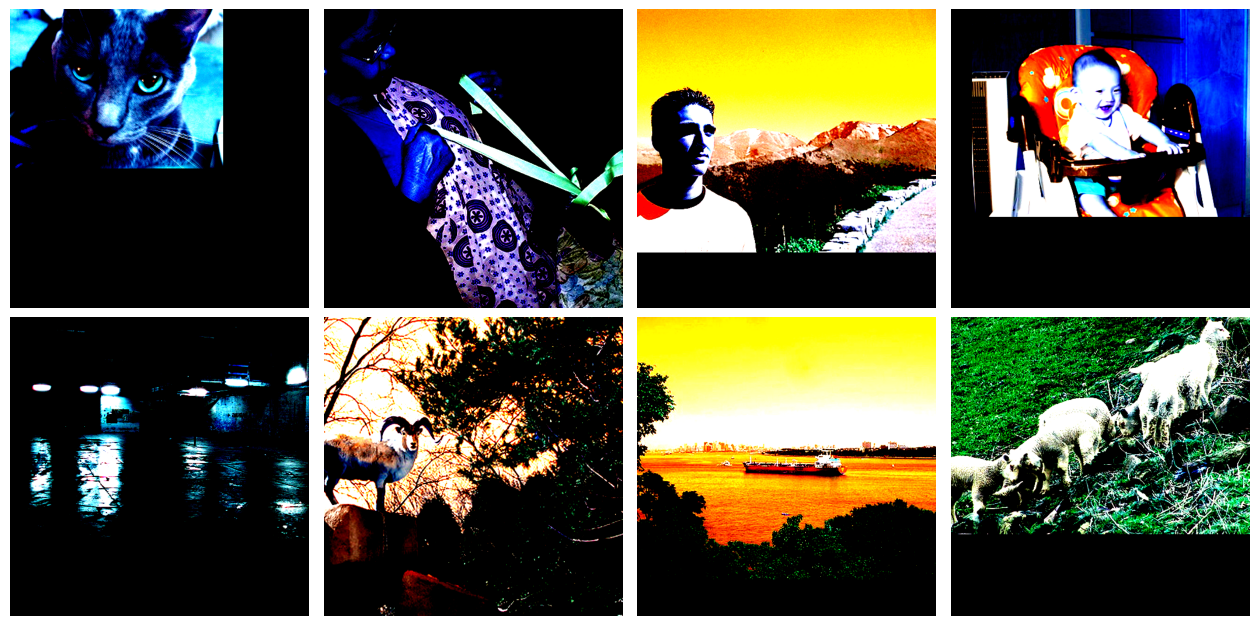

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# 对训练集中的数据进行展示
for i in range(1, 9):
    plt.subplot(2, 4, i)
    show_data = next(dataset_eval.create_dict_iterator())
    show_images = show_data["data"].asnumpy()
    show_images = np.clip(show_images, 0, 1)
# 将图片转换HWC格式后进行展示
    plt.imshow(show_images[0].transpose(1, 2, 0))
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

## 网络构建

### 网络流程

FCN网络的流程如下图所示：

1. 输入图像image，经过pool1池化后，尺寸变为原始尺寸的1/2。
2. 经过pool2池化，尺寸变为原始尺寸的1/4。
3. 接着经过pool3、pool4、pool5池化，大小分别变为原始尺寸的1/8、1/16、1/32。
4. 经过conv6-7卷积，输出的尺寸依然是原图的1/32。
5. FCN-32s是最后使用反卷积，使得输出图像大小与输入图像相同。
6. FCN-16s是将conv7的输出进行反卷积，使其尺寸扩大两倍至原图的1/16，并将其与pool4输出的特征图进行融合，后通过反卷积扩大到原始尺寸。
7. FCN-8s是将conv7的输出进行反卷积扩大4倍，将pool4输出的特征图反卷积扩大2倍，并将pool3输出特征图拿出，三者融合后通反卷积扩大到原始尺寸。

![fcn-6](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_6.png)

使用以下代码构建FCN-8s网络。

In [5]:
import mindspore.nn as nn

class FCN8s(nn.Cell):
    def __init__(self, n_class):
        super().__init__()
        self.n_class = n_class
        self.conv1 = nn.SequentialCell(
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.SequentialCell(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.SequentialCell(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.SequentialCell(
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.SequentialCell(
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv6 = nn.SequentialCell(
            nn.Conv2d(in_channels=512, out_channels=4096,
                      kernel_size=7, weight_init='xavier_uniform'),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        self.conv7 = nn.SequentialCell(
            nn.Conv2d(in_channels=4096, out_channels=4096,
                      kernel_size=1, weight_init='xavier_uniform'),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        self.score_fr = nn.Conv2d(in_channels=4096, out_channels=self.n_class,
                                  kernel_size=1, weight_init='xavier_uniform')
        self.upscore2 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool4 = nn.Conv2d(in_channels=512, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore_pool4 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                                kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool3 = nn.Conv2d(in_channels=256, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore8 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=16, stride=8, weight_init='xavier_uniform')

    def construct(self, x):
        x1 = self.conv1(x)
        p1 = self.pool1(x1)
        x2 = self.conv2(p1)
        p2 = self.pool2(x2)
        x3 = self.conv3(p2)
        p3 = self.pool3(x3)
        x4 = self.conv4(p3)
        p4 = self.pool4(x4)
        x5 = self.conv5(p4)
        p5 = self.pool5(x5)
        x6 = self.conv6(p5)
        x7 = self.conv7(x6)
        sf = self.score_fr(x7)
        u2 = self.upscore2(sf)
        s4 = self.score_pool4(p4)
        f4 = s4 + u2
        u4 = self.upscore_pool4(f4)
        s3 = self.score_pool3(p3)
        f3 = s3 + u4
        out = self.upscore8(f3)
        return out

## 模型推理

下文中使用已训练好的权重文件对模型推理结果进行展示。


file_sizes: 100%|██████████████████████████| 1.08G/1.08G [01:21<00:00, 13.3MB/s]
Successfully downloaded file to FCN8s.ckpt


/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
[ERROR] CORE(10263,ffffa13c9010,python):2024-09-06-09:47:55.932.574 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_10263/2908278656.py]
[ERROR] CORE(10263,ffffa13c9010,python):2024-09-06-09:47:55.932.675 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_10263/2908278656.py]


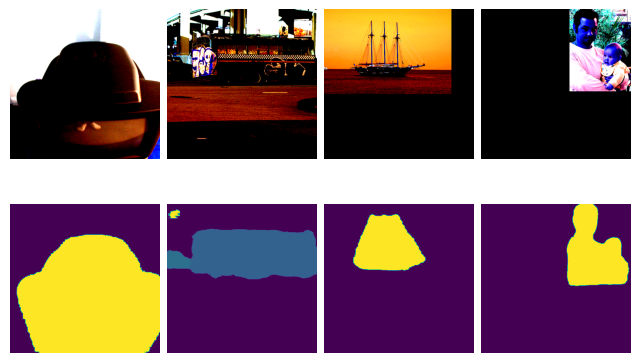

In [6]:
from download import download
from mindspore import load_checkpoint, load_param_into_net
import cv2
import matplotlib.pyplot as plt

# 下载已训练好的权重文件
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/FCN8s.ckpt"
download(url, "FCN8s.ckpt", replace=True)

net = FCN8s(n_class=num_classes)
ckpt_file = "FCN8s.ckpt"
param_dict = load_checkpoint(ckpt_file)
load_param_into_net(net, param_dict)


# 推理效果展示(上方为输入图片，下方为推理效果图片)
plt.figure(figsize=(8, 5))
for i in range(1, 5):
    plt.subplot(2, 4, i)
    show_data = next(dataset_eval.create_dict_iterator())
    show_images = show_data["data"].asnumpy()
    show_images = np.clip(show_images, 0, 1)
    # 将图片转换HWC格式后进行展示
    plt.imshow(show_images[0].transpose(1, 2, 0))
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
    # 语义分割后效果
    plt.subplot(2, 4, i + 4)
    res = net(show_data["data"]).asnumpy().argmax(axis=1)
    plt.imshow(res[0])
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
plt.show()